In [73]:
import os
import re
import numpy as np
import numpy as np
import generated.tracking_data_pb2 as tracking_data_pb2
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns
import math

In [74]:
refer_data = {
    "x_seq": [],
    "y_seq": [],
    "theta_seq": [],
    "v_seq": [],
    "a_seq": [],
    "omega_seq": [],
    "kappa_seq": [],
    "steer_angle": [],
    "steer_angle_rate": [],
}
actual_data = {
    "x_seq": [],
    "y_seq": [],
    "theta_seq": [],
    "v_seq": [],
    "a_seq": [],
    "omega_seq": [],
    "kappa_seq": [],
    "steer_angle": [],
    "steer_angle_rate": [],
}
control_data = {
    "v_seq": [],
    "a_seq": [],
    "omega_seq": [],
    "kappa_seq": [],
    "steer_angle": [],
    "steer_angle_rate": [],
}
timestamps = []
mpc_param = {}
tracking_data = tracking_data_pb2.TrackingData()

In [75]:
"""
load all the data from the proto files
"""


def extract_timestamp(file_name):
    match = re.search(r"tracking_data_(\d+)_(\d+)", file_name)
    if match:
        seconds = int(match.group(1))
        milliseconds = int(match.group(2))
        return (seconds, milliseconds)
    return (0, 0)


data_dir = "/tmp/ros/proto/traj_tracking/"
all_files = os.listdir(data_dir)
file_names = [
    os.path.join(data_dir, f)
    for f in all_files
    if os.path.isfile(os.path.join(data_dir, f))
]
file_names = sorted(file_names, key=extract_timestamp)
print(file_names)
for file_name in file_names:
    with open(file_name, "rb") as f:
        tracking_data.ParseFromString(f.read())
    mpc_param = tracking_data.mpc_param
    timestamps.extend(tracking_data.timestamp)
    for item in tracking_data.reference_data:
        refer_data["x_seq"].append(item.x)
        refer_data["y_seq"].append(item.y)
        refer_data["theta_seq"].append(item.theta)
        refer_data["v_seq"].append(item.v)
        if len(refer_data["v_seq"]) > 1:
            refer_data["a_seq"].append(
                (refer_data["v_seq"][-1] - refer_data["v_seq"][-2]) / mpc_param.interval
            )
        else:
            refer_data["a_seq"].append(0)
        refer_data["omega_seq"].append(item.omega)
        refer_data["kappa_seq"].append(item.kappa)
        refer_data["steer_angle"].append(
            math.atan2(mpc_param.dist_front_to_rear * item.kappa, 1)
        )
        if len(refer_data["steer_angle"]) > 1:
            refer_data["steer_angle_rate"].append(
                (refer_data["steer_angle"][-1] - refer_data["steer_angle"][-2])
                / mpc_param.interval
            )
        else:
            refer_data["steer_angle_rate"].append(0)
    for item in tracking_data.actual_data:
        actual_data["x_seq"].append(item.x)
        actual_data["y_seq"].append(item.y)
        actual_data["theta_seq"].append(item.theta)
        actual_data["v_seq"].append(item.v)
        if len(actual_data["v_seq"]) > 1:
            actual_data["a_seq"].append(
                (actual_data["v_seq"][-1] - actual_data["v_seq"][-2])
                / mpc_param.interval
            )
        else:
            actual_data["a_seq"].append(0)
        actual_data["omega_seq"].append(item.omega)
        actual_data["kappa_seq"].append(item.kappa)
        actual_data["steer_angle"].append(
            math.atan2(mpc_param.dist_front_to_rear * item.kappa, 1)
        )
        if len(actual_data["steer_angle"]) > 1:
            actual_data["steer_angle_rate"].append(
                (actual_data["steer_angle"][-1] - actual_data["steer_angle"][-2])
                / mpc_param.interval
            )
        else:
            actual_data["steer_angle_rate"].append(0)
    # control data
    for item in tracking_data.control_signal:
        control_data["v_seq"].append(item.v)
        if len(control_data["v_seq"]) > 1:
            control_data["a_seq"].append(
                (control_data["v_seq"][-1] - control_data["v_seq"][-2])
                / mpc_param.interval
            )
        else:
            control_data["a_seq"].append(0)
        control_data["omega_seq"].append(item.omega)
        control_data["kappa_seq"].append(item.kappa)
        control_data["steer_angle"].append(
            math.atan2(mpc_param.dist_front_to_rear * item.kappa, 1)
        )
        if len(control_data["steer_angle"]) > 1:
            control_data["steer_angle_rate"].append(
                (control_data["steer_angle"][-1] - control_data["steer_angle"][-2])
                / mpc_param.interval
            )
        else:
            control_data["steer_angle_rate"].append(0)

['/tmp/ros/proto/traj_tracking/tracking_data_5_202', '/tmp/ros/proto/traj_tracking/tracking_data_5_986', '/tmp/ros/proto/traj_tracking/tracking_data_6_785', '/tmp/ros/proto/traj_tracking/tracking_data_7_586', '/tmp/ros/proto/traj_tracking/tracking_data_8_385', '/tmp/ros/proto/traj_tracking/tracking_data_9_185', '/tmp/ros/proto/traj_tracking/tracking_data_9_985', '/tmp/ros/proto/traj_tracking/tracking_data_10_906', '/tmp/ros/proto/traj_tracking/tracking_data_11_705', '/tmp/ros/proto/traj_tracking/tracking_data_12_506', '/tmp/ros/proto/traj_tracking/tracking_data_13_313', '/tmp/ros/proto/traj_tracking/tracking_data_14_110', '/tmp/ros/proto/traj_tracking/tracking_data_14_909', '/tmp/ros/proto/traj_tracking/tracking_data_15_921', '/tmp/ros/proto/traj_tracking/tracking_data_16_729', '/tmp/ros/proto/traj_tracking/tracking_data_17_525', '/tmp/ros/proto/traj_tracking/tracking_data_18_326', '/tmp/ros/proto/traj_tracking/tracking_data_19_124', '/tmp/ros/proto/traj_tracking/tracking_data_19_925',

In [76]:
def plot_tracking_data(
    fig,
    gs,
    timestamps,
    refer_data,
    actual_data,
    control_data=None,
    interval=0.02,
    line_width=1.0,
):
    """
    Plot vehicle trajectory data including reference, actual, and control data.
    :param fig: The figure object to add the subplots.
    :param gs: The GridSpec object defining the grid layout for subplots.
    :param timestamps: Array of timestamps
    :param refer_data: Dictionary containing reference data, with keys "x_seq", "y_seq", "theta_seq", "v_seq", "omega_seq", "kappa_seq"
    :param actual_data: Dictionary containing actual data, with keys "x_seq", "y_seq", "theta_seq", "v_seq", "omega_seq", "kappa_seq"
    :param control_data: Dictionary containing control data, with keys "v_seq", "omega_seq", "kappa_seq" (optional)
    :param interval: Time interval between measurements, default is 0.02
    """

    # Create subplots using GridSpec layout
    ax0_1 = fig.add_subplot(gs[0, 1])
    ax0_2 = fig.add_subplot(gs[0, 2])
    ax0_3 = fig.add_subplot(gs[0, 3])
    ax1_1 = fig.add_subplot(gs[1, 1])
    ax1_2 = fig.add_subplot(gs[1, 2])
    ax1_3 = fig.add_subplot(gs[1, 3])

    # Generate x-axis ticks based on the timestamps and interval
    x_ticks = np.arange(0, len(timestamps) * interval, interval)  # x-axis

    # Define colors from seaborn palette
    refer_color = sns.color_palette("dark")[0]  # First color in "deep" palette
    actual_color = sns.color_palette("dark")[1]  # Second color in "deep" palette
    control_color = sns.color_palette("dark")[2]  # Third color in "deep" palette

    # Plot X sequence
    ax0_1.plot(
        x_ticks,
        refer_data["x_seq"],
        label="refer",
        color=refer_color,
        linewidth=line_width,
    )
    ax0_1.plot(
        x_ticks,
        actual_data["x_seq"],
        label="actual",
        color=actual_color,
        linewidth=line_width,
    )
    ax0_1.set_title("X")
    ax0_1.set_xlabel("Time")
    ax0_1.set_ylabel("x")

    # Plot Y sequence
    ax0_2.plot(
        x_ticks,
        refer_data["y_seq"],
        label="refer",
        color=refer_color,
        linewidth=line_width,
    )
    ax0_2.plot(
        x_ticks,
        actual_data["y_seq"],
        label="actual",
        color=actual_color,
        linewidth=line_width,
    )
    ax0_2.set_title("Y")
    ax0_2.set_xlabel("Time")
    ax0_2.set_ylabel("y")

    # Plot Theta sequence
    ax0_3.plot(
        x_ticks,
        refer_data["theta_seq"],
        label="refer",
        color=refer_color,
        linewidth=line_width,
    )
    ax0_3.plot(
        x_ticks,
        actual_data["theta_seq"],
        label="actual",
        color=actual_color,
        linewidth=line_width,
    )
    ax0_3.set_title("Theta")
    ax0_3.set_xlabel("Time")
    ax0_3.set_ylabel("theta")

    # Plot V sequence (Control data is optional)
    ax1_1.plot(
        x_ticks,
        refer_data["v_seq"],
        label="refer",
        color=refer_color,
        linewidth=line_width,
    )
    ax1_1.plot(
        x_ticks,
        actual_data["v_seq"],
        label="actual",
        color=actual_color,
        linewidth=line_width,
    )
    if control_data:
        ax1_1.plot(
            x_ticks,
            control_data["v_seq"],
            label="control",
            color=control_color,
            linewidth=line_width,
        )
    ax1_1.set_title("V")
    ax1_1.set_xlabel("Time")
    ax1_1.set_ylabel("v")

    # Plot Omega sequence (Control data is optional)
    ax1_2.plot(
        x_ticks,
        refer_data["omega_seq"],
        label="refer",
        color=refer_color,
        linewidth=line_width,
    )
    ax1_2.plot(
        x_ticks,
        actual_data["omega_seq"],
        label="actual",
        color=actual_color,
        linewidth=line_width,
    )
    if control_data:
        ax1_2.plot(
            x_ticks,
            control_data["omega_seq"],
            label="control",
            color=control_color,
            linewidth=line_width,
        )
    ax1_2.set_title("Omega")
    ax1_2.set_xlabel("Time")
    ax1_2.set_ylabel("omega")

    # Plot Kappa sequence (Control data is optional)
    ax1_3.plot(
        x_ticks,
        refer_data["kappa_seq"],
        label="refer",
        color=refer_color,
        linewidth=line_width,
    )
    ax1_3.plot(
        x_ticks,
        actual_data["kappa_seq"],
        label="actual",
        color=actual_color,
        linewidth=line_width,
    )
    if control_data:
        ax1_3.plot(
            x_ticks,
            control_data["kappa_seq"],
            label="control",
            color=control_color,
            linewidth=line_width,
        )
    ax1_3.set_title("Kappa")
    ax1_3.set_xlabel("Time")
    ax1_3.set_ylabel("kappa")
    ax1_3.legend(fontsize="small")

In [77]:
def plot_phase_plane(
    ax,
    states,  # List of states (x, y, yaw) for each time step
    car_length,  # Length of the car (meters)
    car_width,  # Width of the car (meters)
    label,  # Label for the plot
    line_color="black",  # Trajectory line color
    line_style="--",  # Trajectory line style
    contour_color="black",  # Car contour color
    contour_style="--",  # Car contour line style
    interval=5,  # Interval between points to display
):
    # Extract x and y coordinates from the states
    x_coords = [state[0] for state in states]
    y_coords = [state[1] for state in states]

    # Select points to display: first, last, and every 'interval' points in between
    selected_indices = (
        [0] + list(range(1, len(states) - 1, interval)) + [len(states) - 1]
    )
    selected_states = [states[i] for i in selected_indices]

    # Create a plot for the trajectory
    ax.plot(
        x_coords,
        y_coords,
        label=label,
        color=line_color,
        linewidth=2,
        linestyle=line_style,
    )

    # Draw the car at each position
    for state in selected_states:
        x, y, yaw = state

        # Define the car's corners
        corners = np.array(
            [
                [-car_length / 2, -car_width / 2],
                [car_length / 2, -car_width / 2],
                [car_length / 2, car_width / 2],
                [-car_length / 2, car_width / 2],
            ]
        )

        # Rotate corners based on the car's yaw angle
        rotation_matrix = np.array(
            [
                [np.cos(yaw), -np.sin(yaw)],
                [np.sin(yaw), np.cos(yaw)],
            ]
        )
        rotated_corners = np.dot(corners, rotation_matrix.T) + np.array([x, y])

        # Create a polygon for the car
        car_polygon = Polygon(
            rotated_corners,
            closed=True,
            edgecolor=contour_color,
            linestyle=contour_style,
            facecolor="none",
            linewidth=1.5,
        )
        ax.add_patch(car_polygon)

    ax.set_xlabel("X (meters)")
    ax.set_ylabel("Y (meters)")
    ax.set_title("Phase Plane")
    ax.axis("equal")
    ax.grid(True)
    ax.legend()

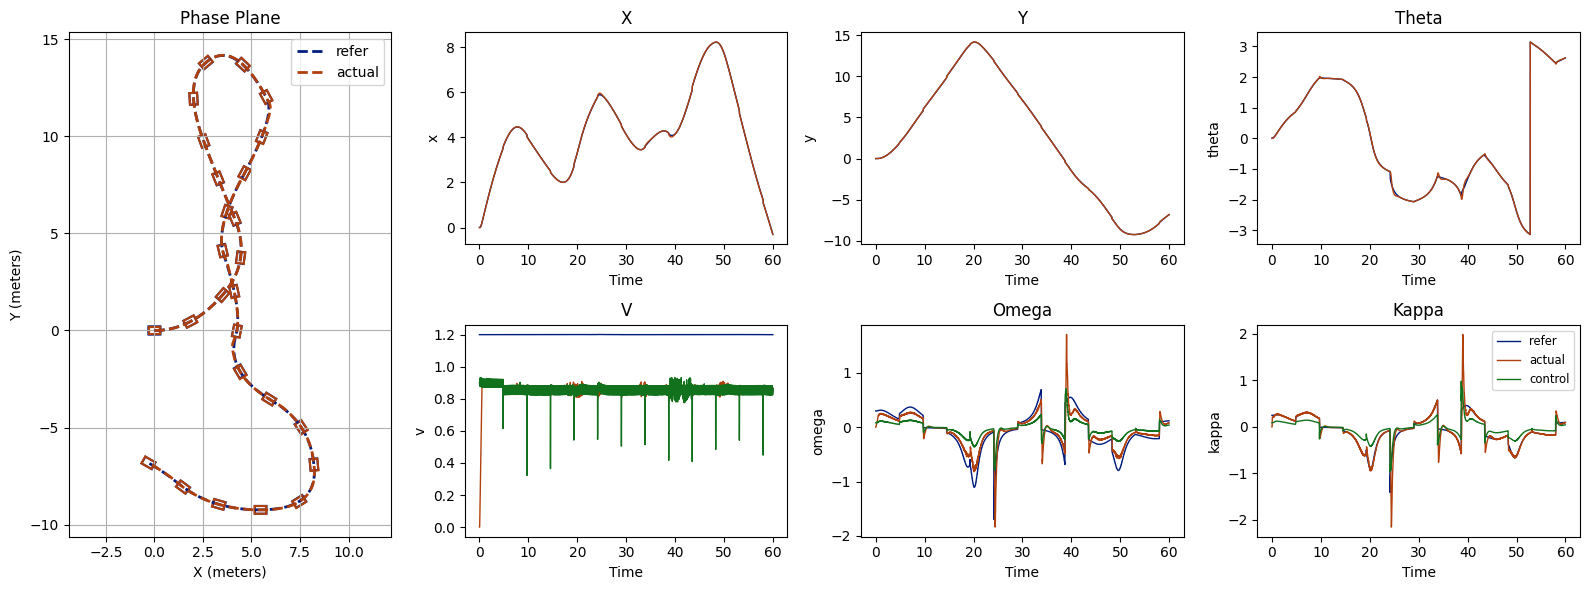

In [78]:
fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(2, 4)
# plot tracking data
plot_tracking_data(fig, gs, timestamps, refer_data, actual_data, control_data)

# plot reference trajectory phase plane
longi_buffer = 0.2
refer_states = [
    [x, y, yaw]
    for x, y, yaw in zip(
        refer_data["x_seq"], refer_data["y_seq"], refer_data["theta_seq"]
    )
]
actual_states = [
    [x, y, yaw]
    for x, y, yaw in zip(
        actual_data["x_seq"], actual_data["y_seq"], actual_data["theta_seq"]
    )
]
ax = fig.add_subplot(gs[0:2, 0:1])
refer_color = sns.color_palette("dark")[0]  # First color in "deep" palette
actual_color = sns.color_palette("dark")[1]  # Second color in "deep" palette
interval = 120
plot_phase_plane(
    ax,
    refer_states,
    tracking_data.mpc_param.dist_front_to_rear + longi_buffer,
    tracking_data.mpc_param.track_width,
    label="refer",
    line_color=refer_color,
    line_style="--",
    contour_color=refer_color,
    contour_style="-",
    interval=interval,
)
plot_phase_plane(
    ax,
    actual_states,
    tracking_data.mpc_param.dist_front_to_rear + longi_buffer,
    tracking_data.mpc_param.track_width,
    label="actual",
    line_color=actual_color,
    line_style="--",
    contour_color=actual_color,
    contour_style="-",
    interval=interval,
)
# Set plot labels and title
plt.tight_layout()
# Show the plot
plt.show()

In [7]:
def plot_tracking_data(
    fig,
    gs,
    timestamps,
    refer_data,
    actual_data,
    control_data=None,
    interval=0.02,
    line_width=1.0,
):
    """
    Plot vehicle trajectory data including reference, actual, and control data.
    :param fig: The figure object to add the subplots.
    :param gs: The GridSpec object defining the grid layout for subplots.
    :param timestamps: Array of timestamps
    :param refer_data: Dictionary containing reference data, with keys "x_seq", "y_seq", "theta_seq", "v_seq", "omega_seq", "kappa_seq"
    :param actual_data: Dictionary containing actual data, with keys "x_seq", "y_seq", "theta_seq", "v_seq", "omega_seq", "kappa_seq"
    :param control_data: Dictionary containing control data, with keys "v_seq", "omega_seq", "kappa_seq" (optional)
    :param interval: Time interval between measurements, default is 0.02
    """

    # Create subplots using GridSpec layout
    ax0_1 = fig.add_subplot(gs[0, 1])
    ax0_2 = fig.add_subplot(gs[0, 2])
    ax0_3 = fig.add_subplot(gs[0, 3])
    ax1_1 = fig.add_subplot(gs[1, 1])
    ax1_2 = fig.add_subplot(gs[1, 2])
    ax1_3 = fig.add_subplot(gs[1, 3])
    ax2_1 = fig.add_subplot(gs[2, 1])
    ax2_2 = fig.add_subplot(gs[2, 2])
    ax2_3 = fig.add_subplot(gs[2, 3])

    # Generate x-axis ticks based on the timestamps and interval
    x_ticks = np.arange(0, len(timestamps) * interval, interval)  # x-axis

    # Define colors from seaborn palette
    refer_color = sns.color_palette("dark")[0]  # First color in "deep" palette
    actual_color = sns.color_palette("dark")[1]  # Second color in "deep" palette
    control_color = sns.color_palette("dark")[2]  # Third color in "deep" palette
    limit_color = sns.color_palette("dark")[3]  # Fourth color in "deep" palette

    def plot_data_series_data(
        ax,
        x_ticks,
        refer_data,
        actual_data,
        control_data=None,
        lb=None,
        ub=None,
        enable_legend=False,
        xlabel="",
        ylabel="",
        title="",
    ):
        ax.plot(
            x_ticks,
            refer_data,
            label="refer",
            color=refer_color,
            linewidth=line_width,
        )
        ax.plot(
            x_ticks,
            actual_data,
            label="actual",
            color=actual_color,
            linewidth=line_width,
        )
        if control_data:
            ax.plot(
                x_ticks,
                control_data,
                label="control",
                color=control_color,
                linewidth=line_width,
            )
        if lb:
            limit_data = [lb] * len(x_ticks)
            ax.plot(
                x_ticks,
                limit_data,
                label="limit",
                color=limit_color,
                linewidth=line_width,
            )
        if ub:
            limit_data = [ub] * len(x_ticks)
            ax.plot(
                x_ticks,
                limit_data,
                color=limit_color,
                linewidth=line_width,
            )
        if enable_legend:
            ax.legend(fontsize="small")
        else:
            ax.legend().remove()
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)

    # Plot X sequence
    plot_data_series_data(
        ax0_1,
        x_ticks,
        refer_data["x_seq"],
        actual_data["x_seq"],
        xlabel="Time",
        ylabel="x",
        title="X",
    )
    plot_data_series_data(
        ax0_2,
        x_ticks,
        refer_data["y_seq"],
        actual_data["y_seq"],
        xlabel="Time",
        ylabel="y",
        title="Y",
    )
    plot_data_series_data(
        ax0_3,
        x_ticks,
        refer_data["theta_seq"],
        actual_data["theta_seq"],
        xlabel="Time",
        ylabel="theta",
        title="Theta",
    )
    plot_data_series_data(
        ax1_1,
        x_ticks,
        refer_data["steer_angle"],
        actual_data["steer_angle"],
        control_data["steer_angle"],
        lb=-mpc_param.front_wheel_angle_limit,
        ub=mpc_param.front_wheel_angle_limit,
        xlabel="Time",
        ylabel="steer_angle",
        title="Steer Angle",
    )
    plot_data_series_data(
        ax1_2,
        x_ticks,
        refer_data["v_seq"],
        actual_data["v_seq"],
        control_data["v_seq"],
        ub=mpc_param.speed_limit,
        xlabel="Time",
        ylabel="v",
        title="V",
    )
    plot_data_series_data(
        ax1_3,
        x_ticks,
        refer_data["a_seq"],
        actual_data["a_seq"],
        control_data["a_seq"],
        lb=-mpc_param.acc_limit,
        ub=mpc_param.acc_limit,
        xlabel="Time",
        ylabel="acc",
        title="Acc",
    )
    plot_data_series_data(
        ax2_1,
        x_ticks,
        refer_data["omega_seq"],
        actual_data["omega_seq"],
        control_data["omega_seq"],
        xlabel="Time",
        ylabel="omega",
        title="Omega",
    )
    plot_data_series_data(
        ax2_2,
        x_ticks,
        refer_data["kappa_seq"],
        actual_data["kappa_seq"],
        control_data["kappa_seq"],
        xlabel="Time",
        ylabel="kappa",
        title="Kappa",
    )
    plot_data_series_data(
        ax2_3,
        x_ticks,
        refer_data["steer_angle_rate"],
        actual_data["steer_angle_rate"],
        control_data["steer_angle_rate"],
        lb=-mpc_param.front_wheel_angle_rate_limit,
        ub=mpc_param.front_wheel_angle_rate_limit,
        enable_legend=True,
        xlabel="Time",
        ylabel="steer_angle_rate",
        title="Steer Angle Rate",
    )

In [ ]:
fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(3, 4)
# plot tracking data
plot_tracking_data(fig, gs, timestamps, refer_data, actual_data, control_data)

# plot reference trajectory phase plane
longi_buffer = 0.2
refer_states = [
    [x, y, yaw]
    for x, y, yaw in zip(
        refer_data["x_seq"], refer_data["y_seq"], refer_data["theta_seq"]
    )
]
actual_states = [
    [x, y, yaw]
    for x, y, yaw in zip(
        actual_data["x_seq"], actual_data["y_seq"], actual_data["theta_seq"]
    )
]
ax = fig.add_subplot(gs[0:3, 0:1])
refer_color = sns.color_palette("dark")[0]  # First color in "deep" palette
actual_color = sns.color_palette("dark")[1]  # Second color in "deep" palette
interval = 120
plot_phase_plane(
    ax,
    refer_states,
    tracking_data.mpc_param.dist_front_to_rear + longi_buffer,
    tracking_data.mpc_param.track_width,
    label="refer",
    line_color=refer_color,
    line_style="--",
    contour_color=refer_color,
    contour_style="-",
    interval=interval,
)
plot_phase_plane(
    ax,
    actual_states,
    tracking_data.mpc_param.dist_front_to_rear + longi_buffer,
    tracking_data.mpc_param.track_width,
    label="actual",
    line_color=actual_color,
    line_style="--",
    contour_color=actual_color,
    contour_style="-",
    interval=interval,
)
# Set plot labels and title
plt.tight_layout()
# Show the plot
plt.show()

In [ ]:
"""
load one specific data file
"""

refer_data_one_file = {
    "x_seq": [],
    "y_seq": [],
    "theta_seq": [],
    "v_seq": [],
    "omega_seq": [],
    "kappa_seq": [],
}
actual_data_one_file = {
    "x_seq": [],
    "y_seq": [],
    "theta_seq": [],
    "v_seq": [],
    "omega_seq": [],
    "kappa_seq": [],
}
control_data_one_file = {"v_seq": [], "omega_seq": [], "kappa_seq": []}
timestamps_one_file = []

file_name = "/tmp/ros/proto/traj_tracking/tracking_data_18_68"
tracking_data_one_file = tracking_data_pb2.TrackingData()
with open(file_name, "rb") as f:
    tracking_data_one_file.ParseFromString(f.read())
timestamps_one_file.extend(tracking_data_one_file.timestamp)
for item in tracking_data_one_file.reference_data:
    refer_data_one_file["x_seq"].append(item.x)
    refer_data_one_file["y_seq"].append(item.y)
    refer_data_one_file["theta_seq"].append(item.theta)
    refer_data_one_file["v_seq"].append(item.v)
    refer_data_one_file["omega_seq"].append(item.omega)
    refer_data_one_file["kappa_seq"].append(item.kappa)
for item in tracking_data_one_file.actual_data:
    actual_data_one_file["x_seq"].append(item.x)
    actual_data_one_file["y_seq"].append(item.y)
    actual_data_one_file["theta_seq"].append(item.theta)
    actual_data_one_file["v_seq"].append(item.v)
    actual_data_one_file["omega_seq"].append(item.omega)
    actual_data_one_file["kappa_seq"].append(item.kappa)
# control data
for item in tracking_data_one_file.control_signal:
    control_data_one_file["v_seq"].append(item.v)
    control_data_one_file["omega_seq"].append(item.omega)
    control_data_one_file["kappa_seq"].append(item.kappa)